In [10]:
import sys
sys.path.append('../../')

In [11]:
from scripts.utils import set_mpl, read_london
set_mpl()
%matplotlib widget


matplotlib settings set


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Prepare data

In [13]:
london_std, london_tou, london_weather, london_twitter = read_london()


london_std = london_std.query('index>"2012-01-01"')
london_weather = london_weather.query('index>"2012-01-01"')
london_twitter = london_twitter.query('index>"2012-01-01"')


    Loading London data from /Users/sdbykov/not_work/swarm_energAIser/0_data/.
    Weather from `meteostat` package.

    STD and ToU tariffs are separated.
    Data resampled (mean) to 1H resolution from original 30min resolution.

    reutrns:
    df_std: pd.DataFrame with STD tariff data
    df_tou: pd.DataFrame with ToU tariff data
    df_weather: pd.DataFrame with weather data
    df_twitter: pd.DataFrame with twitter data (see `0_data/2.2_london_twitter.ipynb` for details)
    
    


In [14]:
missed_frac = london_std.isna().mean(axis = 0).sort_values(ascending = False)
#drop columns with more than xx% missing values
data = london_std.drop(missed_frac[missed_frac > 0.3].index, axis = 1)
homes_col = data.columns
cols = data.columns


#select homes with mean energy consumption close to  0.1
data_cluster = data[cols[ (data[cols].mean() > 0.1) & (data[cols].mean() < 0.15) ]]
data_cluster = data_cluster.T.sample(300).T
print(f"number of homes: {data_cluster.shape[1]}")
power_avg = data_cluster.mean(axis=1).to_frame()
power_avg.columns = ['power_avg']



number of homes: 300


In [15]:
#time series modelling with random forest and covariates
from darts import TimeSeries
from darts.metrics import mape
from darts import concatenate
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr


target_orig = TimeSeries.from_dataframe(power_avg, freq = 'H')

hodidays_covariates = target_orig.add_holidays("UK")['holidays']


temperature_history = london_weather['temp']/np.max(london_weather['temp'])
#perturb temperature to avoid perfect correlation
rolling_std = temperature_history.rolling(24*3).std()
temperature_forecast = temperature_history + np.random.normal(0, rolling_std, size = len(temperature_history))

#temperature_covariate_past = TimeSeries.from_dataframe(temperature_forecast.to_frame(), freq = 'H')
#temperature_covariate_future  = TimeSeries.from_dataframe(temperature_forecast.to_frame(), freq = 'H')
temperature_covariate  = TimeSeries.from_dataframe(temperature_forecast.to_frame(), freq = 'H') #we can use it as past and future, although it is not perfect for past predictions

#twitter_covariate = TimeSeries.from_dataframe(london_twitter[['tweets_total']], freq = 'H')
twitter_covariate = TimeSeries.from_dataframe(london_twitter, freq = 'H')

#datetime encodings (normalized)
datetime_covatiates = concatenate(
    [
        dt_attr(time_index = target_orig, attribute =  "hour", one_hot = False, cyclic = False )/24,
        dt_attr(time_index = target_orig, attribute =  "day_of_week", one_hot = False, cyclic = False )/7,
        dt_attr(time_index = target_orig, attribute =  "month", one_hot = False, cyclic = False )/12,
        dt_attr(time_index = target_orig, attribute =  "day_of_year", one_hot = False, cyclic = False )/365,
    ],
    axis="component",
)

# Model

## data splitting and preprocessing

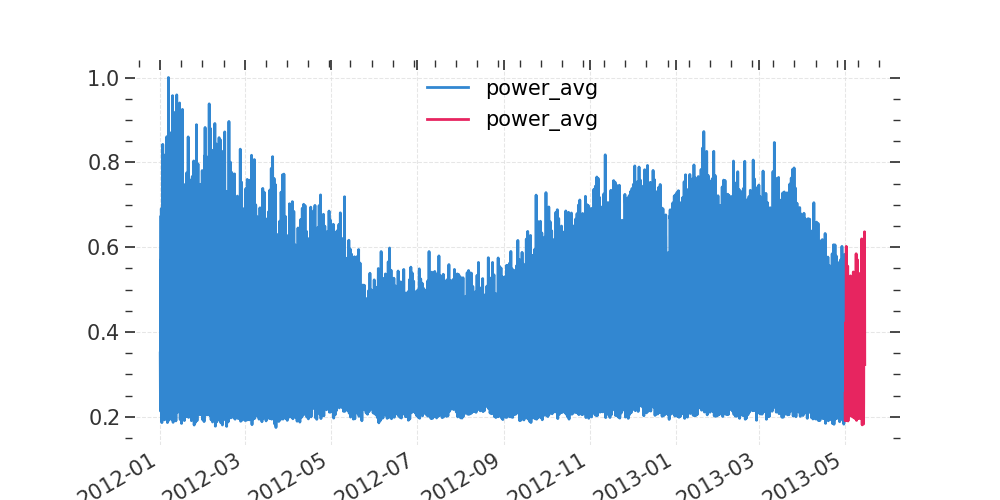

In [16]:
from darts.dataprocessing.transformers import Scaler
from darts.metrics import smape, mape, mase
from sklearn.preprocessing import MaxAbsScaler

timestamp = '2013-05-01'

train, test = target_orig.split_before(pd.Timestamp(timestamp))
test = test.head(168*2)

scaler = Scaler(scaler=MaxAbsScaler())
train = scaler.fit_transform(train)
test = scaler.transform(test)
target = scaler.transform(target_orig)

fig,  ax =  plt.subplots( figsize = (10,5))
train.plot(ax = ax)
test.plot(ax = ax)



## demonstration of effect of model weights

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


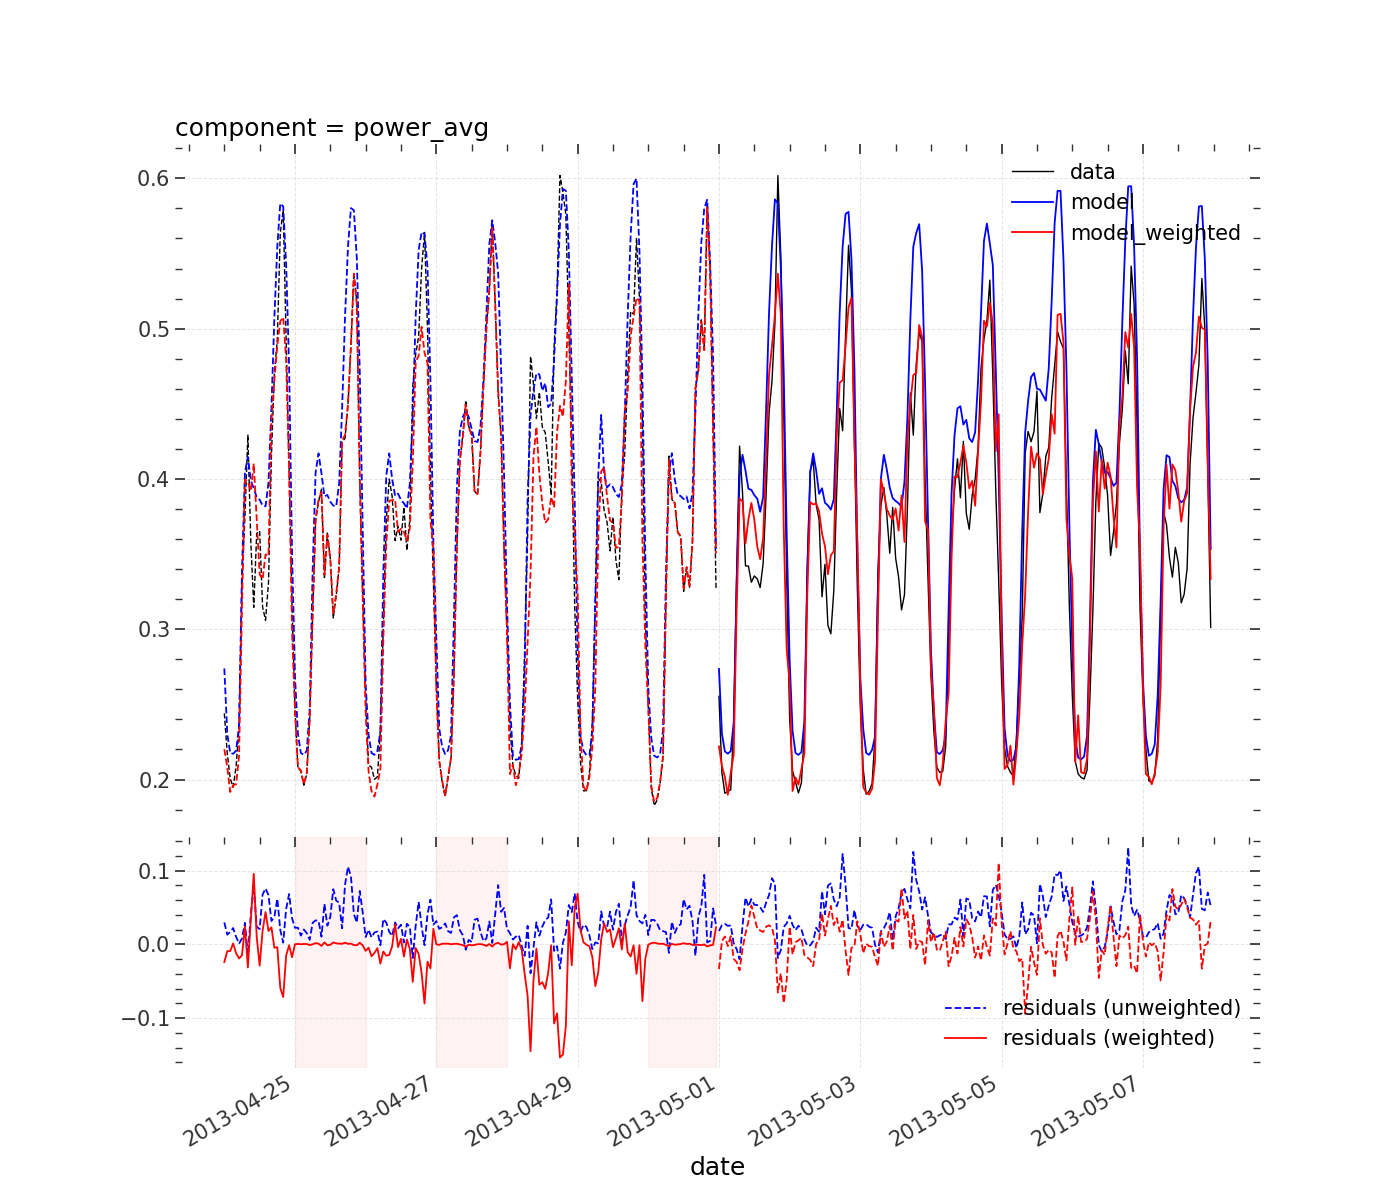

In [45]:
from darts.models import XGBModel

lags_horizon = list(np.hstack([np.arange(1, 25), [168]]))
lags_horizon = [int(x) for x in lags_horizon]
lags_horizon_past = [-int(x) for x in lags_horizon]
lags_horizon_past.sort()
lags_horizon_future = lags_horizon + lags_horizon_past


xgb_args = {'learning_rate' : 0.0655, 'n_estimators': 100, 'max_depth': 3, 'verbosity': 0, 'n_jobs': 4}
#xgb_args = {'verbosity':'1'}

cov_args = {"future_covariates": [datetime_covatiates,hodidays_covariates],
        "past_covariates": [twitter_covariate],}

model = XGBModel(lags_future_covariates = lags_horizon_future , lags_past_covariates=lags_horizon_past,
                              **xgb_args  )                                
model.fit(train, **cov_args)


model_weighted = XGBModel(lags_future_covariates = lags_horizon_future , lags_past_covariates=lags_horizon_past,
                              **xgb_args  )    
#make weights for showcase: make large weights for last training day
weights = np.ones(len(train))*0
weights = weights[168:] #CHECK THIS
#weights_indeces = train.time_index
#weights_indeces = weights_indeces[168:]
#weights[weights_indeces.hour.isin([16,17,18,19,20,21,22])] = 1e5

weights_limits_list = [[-24*6, -24*5], [-24*4, -24*3],[-24*1, -1]]
for weights_limits in weights_limits_list:
        weights[weights_limits[0]:weights_limits[1]] = 1e6

model_weighted.fit(train, sample_weight = weights , **cov_args)



horizon = 24*7 #how many hours ahead


pred_test = model.predict(horizon, train)
pred_train = model.predict(horizon, train.head(-horizon), )


pred_test_weighted = model_weighted.predict(horizon, train)
pred_train_weighted = model_weighted.predict(horizon, train.head(-horizon), )



fig, axs =  plt.subplots(nrows=2, ncols = 1, sharex = True, gridspec_kw = {'hspace':0, 'height_ratios': [3,1]}, figsize = (14,12))
ax, ax_weights = axs
test.head(horizon).plot(ax = ax, label = 'data', lw = 1, alpha = 0.1, color = 'k')
train.tail(horizon).plot(ax = ax, label = '_train', lw = 1, alpha = 0.1, color = 'k', ls = '--')

pred_test.plot(ax = ax, label = 'model', lw = 1.3, alpha = 0.5, color = 'b',)
pred_train.plot(ax = ax, label = '_train', lw = 1.3, alpha = 0.5, color = 'b', ls = '--')


pred_test_weighted.plot(ax = ax, label = 'model_weighted', lw = 1.3, alpha = 0.5, color = 'r',)
pred_train_weighted.plot(ax = ax, label = '_train_weighted', lw = 1.3, alpha = 0.5, color = 'r', ls = '--')


(pred_train-train.tail(horizon)).plot(ax = ax_weights, label = 'residuals (unweighted)', lw = 1.3, alpha = 0.5, color = 'b', ls = '--')
(pred_test - test.head(horizon)).plot(ax = ax_weights, label = '_test', lw = 1.3, alpha = 0.5, color = 'b', ls = '--')


(pred_train_weighted-train.tail(horizon)).plot(ax = ax_weights, label = 'residuals (weighted)', lw = 1.3, alpha = 0.5, color = 'r',)
(pred_test_weighted - test.head(horizon)).plot(ax = ax_weights, label = '_test', lw = 1.3, alpha = 0.5, color = 'r', ls = '--')



for indeces in weights_limits_list:
    ax_weights.axvspan(train.time_index[indeces[0]], train.time_index[indeces[1]], alpha=0.05, color='red')


ax.legend()
ax_weights.legend()

## XGB (with and without humen behaviour) and Naive models

In [ ]:
from darts.models import XGBModel, LinearRegressionModel


#lags_horizon = list(np.hstack([np.arange(1, 25)]))
lags_horizon = list(np.hstack([np.arange(1, 25), [168]]))
lags_horizon = [int(x) for x in lags_horizon]
lags_horizon_past = [-int(x) for x in lags_horizon]
lags_horizon_past.sort()
lags_horizon_future = lags_horizon + lags_horizon_past


model_naive = LinearRegressionModel(lags_past_covariates=[-168])
model_naive.fit(train, past_covariates = target)
print(model_naive.model.coef_, model_naive.model.intercept_)

xgb_args = {'learning_rate' : 0.0655, 'n_estimators': 100, 'max_depth': 3, 'verbosity': 0, 'n_jobs': 4}
# xgb_args = {'learning_rate' : 0.05, 'n_estimators': 100, 'max_depth': 3, 'verbosity': 0, 'n_jobs': 4} gave better performance compared with no twitter and no holiday

#xgb_args = {'verbosity':'1'}
model = XGBModel(lags_future_covariates = lags_horizon_future , lags_past_covariates=lags_horizon_past,
                              **xgb_args  )

                                
cov_args = {"future_covariates": [datetime_covatiates,hodidays_covariates],
        "past_covariates": [twitter_covariate],}

model.fit(train, **cov_args)



models = [model_naive, model]
names = ['naive',  'model']
colors = ['C3', 'C1']
alphas = [0.5, 1]
lws = [0.8, 1.5]


horizon = 168 #how many hours ahead


fig,  ax =  plt.subplots( figsize = (12,8))

val.head(horizon).plot(ax = ax, label = 'data', lw = 2, alpha = 0.1, color = 'k')
train.tail(24*2).plot(ax = ax, label = '_train', lw = 2, alpha = 0.1, color = 'k', ls = '--')



for model, name, color, alpha, lw in zip(models, names, colors, alphas, lws):
    print(name)
    pred_tail_train = model.predict(horizon, train.head(-horizon))
    pred_tail_train.tail(24*2).plot(ax = ax,  lw = lw, alpha = alpha, color =color, label = '_'+name, ls = '--')


    pred = model.predict(horizon)
    pred.plot(ax = ax, label = name, lw = lw, alpha = alpha, color = color)


    model_mape_test = mape(val, pred)
    model_mape_train = mape(train, pred_tail_train)

    print(f"{name} mape  (train): {model_mape_train:2f}")
    print(f"{name} mape  (test): {model_mape_test:2f}")

ax.legend()

ax.set_xlim()



In [ ]:
cov_args = {"future_covariates": [datetime_covatiates,hodidays_covariates],
        "past_covariates": [twitter_covariate],}
model_weighted = XGBModel(lags_future_covariates = lags_horizon_future , lags_past_covariates=lags_horizon_past,
                              **xgb_args  )


weights = np.ones(len(train))
weights_indeces = train.time_index
weights = weights[168:] #CHECK THIS
weights_indeces = weights_indeces[168:]

weights[weights_indeces.hour.isin([16,17,18,19,20,21,22])] = 1e5

#weights[:-24*4] = 0
#weights_limits = [-168, -24*4]
#weights[weights_limits[0]:weights_limits[1]] = 1e6

#Check failed: weights_.Size() == num_row_ (8783 vs. 8615) : Size of weights must equal to number of rows
#after making max lag 77:  (8783 vs. 8717)
model_weighted.fit(train, sample_weight = weights , **cov_args)


fig,  ax =  plt.subplots( figsize = (12, 6))

val.head(horizon).plot(ax = ax, label = 'data', lw = 2, alpha = 0.1, color = 'k')
train.tail(168).plot(ax = ax, label = '_train', lw = 2, alpha = 0.1, color = 'k', ls = '--')

(0.1+train[weights_limits[0]:weights_limits[1]]).plot(ax = ax, label = 'weights', lw = 1, alpha = 0.1, color = 'r')

for model, name, color, alpha, lw in zip(models[:], names[:], colors[:], alphas[:], lws[:]):
    print(name)
    pred_tail_train = model.predict(horizon, train.head(-horizon))
    pred_tail_train.plot(ax = ax,  lw = lw, alpha = alpha, color =color, label = '_'+name, ls = '--')


    pred = model.predict(horizon)
    pred.plot(ax = ax, label = name, lw = lw, alpha = alpha, color = color)


    model_mape_test = mape(val, pred)
    model_mape_train = mape(train, pred_tail_train)

    print(f"{name} mape  (train): {model_mape_train:2f}")
    print(f"{name} mape  (test): {model_mape_test:2f}")

ax.legend()

ax.set_xlim()




In [ ]:
#check if xgboost make a chained prediction by predicting the first value of the test set and then using the prediction as input for the next prediction
pred0 = model.predict(2)

pred1= model.predict(1)
new_history1 = train.append(pred1)
pred2 = model.predict(1, new_history1)
new_history2 = new_history1.append(pred2)

assert np.all(np.vstack([pred1[0].values()[0], pred2[0].values()[0]]) ==pred0.values())

### 1 month horizon

In [ ]:

fig,  ax =  plt.subplots( figsize = (12,6))
for model, name in zip(models, names):

    pred = model.predict(horizon)
    model_mape_test = mape(val, pred)

    print(f"{name} mape  (test): {model_mape_test:2f}")

    res = val - pred
    res.plot(ax = ax, label = name, lw = 1, alpha = 0.5)

In [ ]:
horizon = 744 #how many hours ahead


fig, axs =  plt.subplots(nrows=2, ncols = 1, sharex = True, gridspec_kw = {'hspace':0, 'height_ratios': [3,1]}, figsize = (12,12))
ax, ax_twi = axs
val.plot(ax = ax, label = 'data', lw = 2, alpha = 0.1, color = 'k')
train.tail(24*2).plot(ax = ax, label = '_train', lw = 2, alpha = 0.1, color = 'k', ls = '--')



for model, name, color, alpha, lw in zip(models, names, colors, alphas, lws):
    print(name)
    pred_tail_train = model.predict(horizon, train.head(-horizon))
    pred_tail_train.tail(24*2).plot(ax = ax,  lw = lw, alpha = alpha, color =color, label = '_'+name, ls = '--')


    pred = model.predict(horizon)
    pred.plot(ax = ax, label = name, lw = lw, alpha = alpha, color = color)


    model_mape_test = mape(val, pred)
    model_mape_train = mape(train, pred_tail_train)

    print(f"{name} mape  (train): {model_mape_train:2f}")
    print(f"{name} mape  (test): {model_mape_test:2f}")

ax.legend()

ax.set_xlim()

twitter_covariate.plot(ax = ax_twi, label = 'twitter', lw = 2, alpha = 0.1)


### 1 week horizon

In [ ]:
horizon = 24*7*1 #how many hours ahead


fig,  axs =  plt.subplots(2,  figsize = (12,12))
[ax_head, ax_tail] = axs
val.head(horizon).plot(ax = ax_head, label = 'val', lw = 2, alpha = 0.1, color = 'k')
train.tail(horizon).plot(ax = ax_head, label = 'train', lw = 2, alpha = 0.1, color = 'k', ls = '--')
val.tail(horizon+horizon//7).plot(ax = ax_tail, label = 'val', lw = 2, alpha = 0.1, color = 'k')


for model, name, color, alpha, lw in zip(models, names, colors, alphas, lws):
    print(name)
    pred_tail_train = model.predict(horizon, train.head(-horizon))
    pred_tail_train.plot(ax = ax_head,  lw = lw, alpha = alpha, color =color, label = name, ls = '--')


    pred_head = model.predict(horizon)
    pred_head.plot(ax = ax_head, label = name, lw = lw, alpha = alpha, color = color)

    pred_tail = model.predict(horizon, val.head(-horizon)) #**cov_args may or may not  be needed 

    pred_tail.plot(ax = ax_tail,  lw = lw, alpha = alpha, color =color, label = name)



    model_mape_head = mape(val, pred_head)
    model_mape_tail = mape(val, pred_tail)
    model_mape_tail_train = mape(train, pred_tail_train)

    print(f"{name} mape head (train): {model_mape_tail_train:2f}")
    print(f"{name} mape head (test): {model_mape_head:2f}")
    print(f"{name} mape tail (test): {model_mape_tail:2f}")


### 1 week horizon in past future

## 1 week in past future with retraining on the fly

In [ ]:
lags_horizon = list(np.hstack([np.arange(1, 25), [168]]))
lags_horizon = [int(x) for x in lags_horizon]
lags_horizon_past = [-int(x) for x in lags_horizon]
lags_horizon_past.sort()
lags_horizon_future = lags_horizon + lags_horizon_past

model_naive = LinearRegressionModel(lags_past_covariates=[-168])


cov_args = {"future_covariates": [datetime_covatiates,hodidays_covariates],
        "past_covariates": [twitter_covariate],}

xgb_args = {'learning_rate' : 0.0655, 'n_estimators': 100, 'max_depth': 3, 'verbosity': 0, 'n_jobs': 4}

model = XGBModel(lags_future_covariates = lags_horizon_future , lags_past_covariates=lags_horizon_past,
                              **xgb_args  )

                                


def make_point_prediction(query_date = '2013-07-01', 
                            horizon = 24*7,
                            ):



    train, test = target_orig.split_before(pd.Timestamp(query_date)) 

    scaler = Scaler(scaler=MaxAbsScaler())
    train = scaler.fit_transform(train)
    test = scaler.transform(test)
    target_orig_scaled = scaler.transform(target_orig)


    model_naive.fit(train, past_covariates = target_orig_scaled)
    model_naive.model.coef_ = np.array([1.0])#model_naive.model.coef_ * 0.5
    model_naive.model.intercept_ = 0.0


    model.fit(train, **cov_args)


    model_naive_pred = model_naive.predict(horizon, train)
    model_pred = model.predict(horizon, train)

    model_pred = (model_pred+model_naive_pred)/2

    model_mape = mape(test, model_pred)
    model_naive_mape = mape(test, model_naive_pred)

    print(f"model naive mape: {model_naive_mape:2f}")
    print(f"model mape: {model_mape:2f}")




    fig, axs =  plt.subplots(nrows=2, ncols = 1, sharex = True, gridspec_kw = {'hspace':0, 'height_ratios': [3,1]}, figsize = (14,8))
    ax, ax_twi = axs

    train.tail(horizon//7).plot(ax = ax, label = 'data', lw = 2, alpha = 0.1, color = 'k', ls = ':')
    test.head(horizon).plot(ax = ax, label = 'target', lw = 2, alpha = 0.1, color = 'k', ls = '-')

    ax.set_xlim()

    twitter_covariate.plot(ax = ax_twi, label = 'twitter', lw = 2, alpha = 0.1)


    model_naive_pred.plot(ax = ax, label = 'model naive', lw = 1, alpha = 0.8, color = 'C2')
    model_pred.plot(ax = ax, label = 'model', lw = 1, alpha = 0.8, color = 'C1')

    ax.legend()

make_point_prediction(query_date = '2013-07-01')

make_point_prediction(query_date = '2013-10-01')


## 1 week in future but fitting the residuals from last week's energy consumption

In [ ]:
lags_horizon = list(np.hstack([np.arange(1, 25), [168]]))
lags_horizon = [int(x) for x in lags_horizon]
lags_horizon_past = [-int(x) for x in lags_horizon]
lags_horizon_past.sort()
lags_horizon_future = lags_horizon + lags_horizon_past

model_naive = LinearRegressionModel(lags_past_covariates=[-168])


cov_args = {"future_covariates": [datetime_covatiates,hodidays_covariates],
        "past_covariates": [twitter_covariate],}

xgb_args = {'learning_rate' : 0.0655, 'n_estimators': 100, 'max_depth': 3, 'verbosity': 0, 'n_jobs': 4}

model = XGBModel(lags_future_covariates = lags_horizon_future , lags_past_covariates=lags_horizon_past,
                              **xgb_args  )

                                


def make_point_prediction(query_date = '2013-07-01', 
                            horizon = 24*7,
                            ):



    train, test = target_orig.split_before(pd.Timestamp(query_date)) 

    scaler = Scaler(scaler=MaxAbsScaler())
    train = scaler.fit_transform(train)
    test = scaler.transform(test)
    target_orig_scaled = scaler.transform(target_orig)


    model_naive.fit(train, past_covariates = target_orig_scaled)
    model_naive.model.coef_ = np.array([1.0])#model_naive.model.coef_ * 0.5
    model_naive.model.intercept_ = 0.0
    model_naive_pred = model_naive.predict(horizon, train)
    model_naive_pred_train = model_naive.predict(len(train), train)

    model.fit(train-model_naive_pred_train, **cov_args)


    model_pred = model.predict(horizon, train)+model_naive_pred

    #model_pred = (model_pred+model_naive_pred)/2

    model_mape = mape(test, model_pred)
    model_naive_mape = mape(test, model_naive_pred)

    print(f"model naive mape: {model_naive_mape:2f}")
    print(f"model mape: {model_mape:2f}")




    fig, axs =  plt.subplots(nrows=2, ncols = 1, sharex = True, gridspec_kw = {'hspace':0, 'height_ratios': [3,1]}, figsize = (14,8))
    ax, ax_twi = axs

    train.tail(horizon//7).plot(ax = ax, label = 'data', lw = 2, alpha = 0.1, color = 'k', ls = ':')
    test.head(horizon).plot(ax = ax, label = 'target', lw = 2, alpha = 0.1, color = 'k', ls = '-')

    ax.set_xlim()

    twitter_covariate.plot(ax = ax_twi, label = 'twitter', lw = 2, alpha = 0.1)


    model_naive_pred.plot(ax = ax, label = 'model naive', lw = 1, alpha = 0.8, color = 'C2')
    model_pred.plot(ax = ax, label = 'model', lw = 1, alpha = 0.8, color = 'C1')

    ax.legend()

make_point_prediction(query_date = '2013-07-01')

make_point_prediction(query_date = '2013-10-01')


# Naive model function


In [ ]:
from darts import TimeSeries
from darts.metrics import mape
from darts.models import LinearRegressionModel

def naive_model(df, timestep = '2013-07-01', horizon = 24*7):

    target_orig = TimeSeries.from_dataframe(df, freq = 'H')
    train, test = target_orig.split_before(pd.Timestamp(timestep))

    model = LinearRegressionModel(lags_past_covariates=[-168])
    weights = np.ones(len(train.tail(-168)))
    #weights[-1] = 1e6
    model.fit(train, past_covariates = target_orig, sample_weight = weights)

    #force 1:1 with 168 hours lag
    model.model.coef_ = np.array([1.0])
    model.model.intercept_ = 0.0

    test_pred = model.predict(horizon, train)
    model_mape = mape(test, test_pred)

    return test_pred,test,  model_mape


pred, true,  metr = naive_model(df = power_avg, timestep = '2013-07-01', horizon = 24*7)

fig,  ax =  plt.subplots( figsize = (10,6))
pred.plot(ax = ax, label = 'model naive', lw = 1, alpha = 0.8, color = 'C2')
true.head(24*7).plot(ax = ax, label = 'target', lw = 1, alpha = 0.8, color = 'C1')